## Importing necessary packages and data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# Load the necessary data files
swap_discount_curve = pd.read_excel('../data/discount_curve_swaps.xlsx', sheet_name=0, index_col='maturity')

swap_rates_interpolated = pd.read_excel('../data/discount_curve_swaps.xlsx', sheet_name=1, index_col='maturity')

swap_rates_benchmark = pd.read_excel('../data/discount_curve_swaps.xlsx', sheet_name=2, index_col='maturity')

swap_rates_quotes = pd.read_excel('../data/discount_curve_swaps.xlsx', sheet_name=3, index_col='maturity')

In [3]:
# Display few rows of the data for all dataframes
display(swap_discount_curve.head().style.set_caption('Swap Discount Curve'))

display(swap_rates_interpolated.head().style.set_caption('Swap Rates Interpolated'))

display(swap_rates_benchmark.head().style.set_caption('Swap Rates Benchmark'))

display(swap_rates_quotes.head().style.set_caption('Swap Rates Quotes'))

,last update,swap rate,spot disc rate
maturity,,,
2025-10-01 00:00:00,2025-07-28 00:00:00,0.043342,0.044119
2026-01-01 00:00:00,2025-07-28 00:00:00,0.042236,0.042740
2026-04-01 00:00:00,2025-07-28 00:00:00,0.041237,0.041503
2026-07-01 00:00:00,2025-07-28 00:00:00,0.040290,0.040339
2026-10-01 00:00:00,2025-07-28 00:00:00,0.039257,0.039340


,rate,last update
maturity,,
2025-10-01 00:00:00,0.043363,2025-07-28 00:00:00
2026-01-01 00:00:00,0.042287,2025-07-28 00:00:00
2026-04-01 00:00:00,0.041309,2025-07-28 00:00:00
2026-07-01 00:00:00,0.040358,2025-07-28 00:00:00
2026-10-01 00:00:00,0.039303,2025-07-28 00:00:00


,tenor,rate,last update
maturity,,,
2025-08-04 00:00:00,1W,0.043540,2025-07-28 00:00:00
2025-08-11 00:00:00,2W,0.043510,2025-07-28 00:00:00
2025-08-18 00:00:00,3W,0.043510,2025-07-28 00:00:00
2025-08-28 00:00:00,1M,0.043520,2025-07-28 00:00:00
2025-09-28 00:00:00,2M,0.043390,2025-07-28 00:00:00


,2025-06-30 00:00:00
maturity,
0.251882,4.301900
0.503765,4.146650
0.750171,3.999060
0.999316,3.866730
1.251198,3.720500


In [9]:
# Utility Function
def get_year_frac(start_date, end_date):
    """
    Calculates year fraction between dates using ACT/360 convention.
    Ensures output is a float for scalar inputs or numpy array for series.
    """
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Calculate difference in days
    diff = end - start
    
    # Handle both scalar and Series/Index inputs
    if isinstance(diff, pd.Series) or isinstance(diff, pd.Index):
        days = diff.days
    else:
        days = diff.days
        
    return days / 360.0

# Define valuation date (t=0) from the 'last update' column
val_date = pd.to_datetime(swap_discount_curve['last update'].iloc[0])

# Pre-calculate T (maturity in years) for the main dataset
swap_discount_curve['T'] = get_year_frac(val_date, swap_discount_curve.index)
swap_discount_curve = swap_discount_curve.sort_values('T')

## 1. Fitting the SOFR-Swap Discount Curves

### 1.1 Fitting SOFR-Swap Discount Curves with Continuous & Annual Compounding

#### Mathematical Derivation

Let $r_{ann}(T)$ be the annually compounded spot rate for maturity $T$. The discount factor $Z(0,T)$ is:

$$
Z(0,T) = \frac{1}{(1 + r_{ann}(T))^T}
$$

Let $r_{cont}(T)$ be the continuously compounded equivalent. The discount factor is:

$$
Z(0,T) = e^{-r_{cont}(T) \cdot T}
$$

Equating the two discount factors:

$$
e^{-r_{cont}(T) \cdot T} = (1 + r_{ann}(T))^{-T}
$$

Taking the natural logarithm to solve for $r_{cont}(T)$:

$$
r_{cont}(T) = \ln(1 + r_{ann}(T))
$$

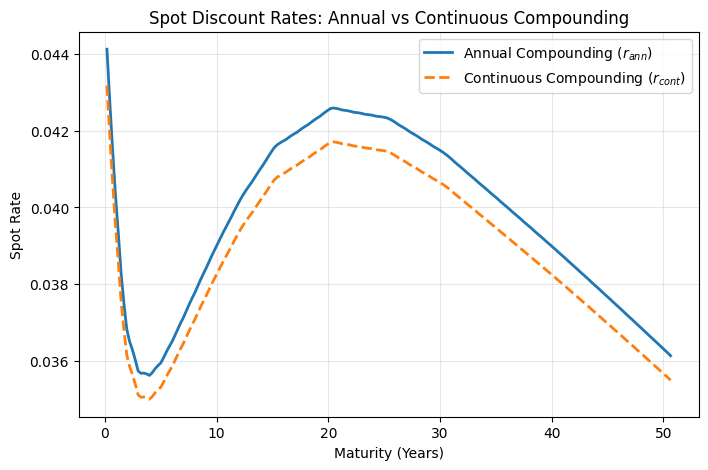

In [13]:
# Extract Annual Rates
r_ann = swap_discount_curve['spot disc rate'].astype(float)

# Convert to Continuous Rates
# r_cont = ln(1 + r_ann)
r_cont = np.log(1 + r_ann)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(swap_discount_curve['T'], r_ann, label='Annual Compounding ($r_{ann}$)', linewidth=2)
plt.plot(swap_discount_curve['T'], r_cont, label='Continuous Compounding ($r_{cont}$)', linestyle='--', linewidth=2)

plt.title('Spot Discount Rates: Annual vs Continuous Compounding')
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Store continuous rate back in DF for later use
swap_discount_curve['r_cont'] = r_cont

### 1.2 Discount Factors

#### Mathematical Derivation

Using the annually compounded rates provided:

$$
Z(0,T) = (1 + r_{ann})^{-T}
$$

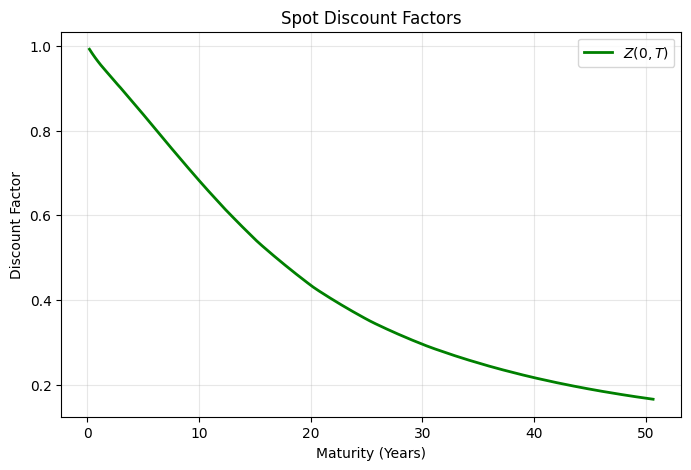

In [15]:
# Calculate Discount Factors
# DF = 1 / (1 + r)^T
discount_factors = 1 / ((1 + r_ann) ** swap_discount_curve['T'])

# Store in DataFrame
swap_discount_curve['discount_factor'] = discount_factors

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(swap_discount_curve['T'], discount_factors, color='green', linewidth=2, label='$Z(0,T)$')

plt.title('Spot Discount Factors')
plt.xlabel('Maturity (Years)')
plt.ylabel('Discount Factor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 1.4 Forward Curve

**Methodology:**  
The forward discount factor $Z(0, T_1, T_2)$ represents the price today of a contract to receive $\$1$ at time $T_2$, with the purchase price paid at time $T_1$.

Under no-arbitrage conditions:
$$
Z(0, T_1, T_2) = \frac{Z(0, T_2)}{Z(0, T_1)}
$$

To find the continuously compounded forward rate $f(T_1, T_2)$ for that interval, we use the relationship:
$$
Z(0, T_1, T_2) = e^{-f(T_1, T_2) \cdot (T_2 - T_1)}
$$

Solving for $f(T_1, T_2)$ by taking the natural logarithm:
$$
f(T_1, T_2) = -\frac{\ln(Z(0, T_1, T_2))}{T_2 - T_1}
$$

This approach first determines the forward discount factor (which is the "price" of the forward interval) and then converts it to a forward rate, which is equivalent to the difference in the logs of the spot discount factors.

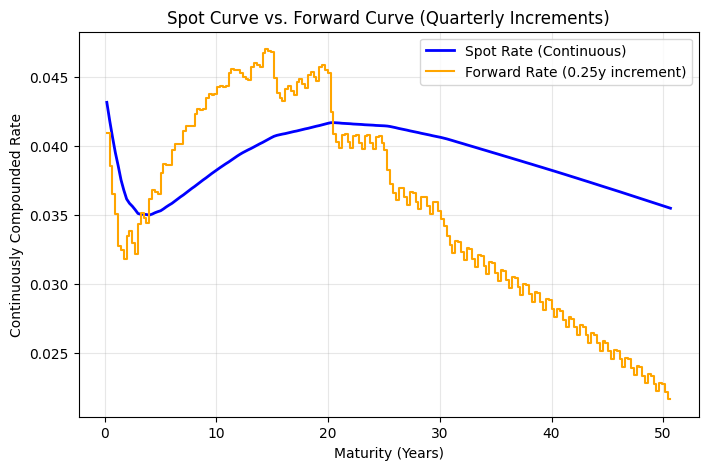

In [26]:
# Forward Curve Calculation
# Copy the DataFrame
df_fwd = swap_discount_curve.copy()

# Calculate forward discount factors: Z(0, T_curr) / Z(0, T_prev)
df_fwd['fwd_factor'] = df_fwd['discount_factor'] / df_fwd['discount_factor'].shift(1)

# Time difference between adjacent maturities
df_fwd['dT'] = df_fwd['T'].diff()

# Continuously compounded forward rate for each interval
df_fwd['fwd_rate'] = -np.log(df_fwd['fwd_factor']) / df_fwd['dT']

# Plot spot curve and forward curve
plt.figure(figsize=(8, 5))
plt.plot(df_fwd['T'], df_fwd['r_cont'], label='Spot Rate (Continuous)', color='blue', linewidth=2)
plt.step(df_fwd['T'], df_fwd['fwd_rate'], where='pre', label='Forward Rate (0.25y increment)', color='orange')
plt.title('Spot Curve vs. Forward Curve (Quarterly Increments)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Continuously Compounded Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()